In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import distance_measures
import math
import os
import sys
from docplex.mp.model import Model  #import the Model class from docplex.mp

In [ ]:
# path

n = 50

path ='./'
# data_path = path + 'Inputs/G'+str(n)+'.txt'  
result_path = path +'Outputs/G'+str(n)+'_SIR_result.txt'

deg = [5,7,10]
T = 70 # time period
B = 5 # budget
s = 0.99 # threshold
s = np.log(1/(1-s))
M = 9999

a = 0.015
b = 0.05
c = 0.3
d = 0.9

a = np.log(1/(1-a))
b = np.log(1/(1-b))
c = np.log(1/(1-c))
d = np.log(1/(1-d))

data = list(range(1,n+1))
V = data

V1=[16, 38, 49, 2, 5, 26, 12, 50, 7, 48, 41, 29, 23, 39, 20, 10, 47, 42, 8, 11, 1, 34, 30, 21, 4]
V2=[46, 14, 22, 9, 36, 44, 37, 3, 32, 17, 31, 33, 43, 27, 6, 35, 19, 25, 24, 40, 18, 13, 45, 28, 15]

SIR_infected = []
SIR_recovered = []

In [ ]:
# SIR optimization model

def SIR(B,degg,rT = 25, T=70, t0=3):

    # create the model
    m =Model()

    # create variables
    #x = {(i,j): m.continuous_var(name='x_{0}_{1}'.format(i,j)) for i in source for j in target if (i,j) in costs}
    #x = {i:m.binary_var() for i in range(1,n+1)}
    x = m.binary_var_matrix(range(1,n+1), range(T+1), "x")
    y = m.binary_var_matrix(range(1,n+1), range(T+1), "y")
    
    # objective function

    obj=m.sum(x[i,T]+y[i,T] for i in V)
    #print(obj)

    # add constraints

    constr1 = m.sum(x[i,0]  for i in V) <=B   
    m.add_constraint(constr1)

    #constr2 = [m.sum(x[j,t-1]*w[j,i] for j in nbs[i])>=s*(x[i,t]-x[i,t-1]) for i in V for t in range(1,T+1)]
    constr2 = [m.sum(x[j,k-1]*w[j,i] for k in range(max(1,t-t0+1),t+1) for j in nbs[i])>=s*(x[i,t]-x[i,t-1]) for i in V for t in range(1,T+1)]
    m.add_constraints(constr2)

    constr = [m.sum(x[j,k-1]*w[j,i] for k in range(max(1,t-t0+1),t+1) for j in nbs[i])<=s+ M*(x[i,t]+y[i,t]) for i in V for t in range(1,T+1)]
    m.add_constraints(constr)

    constr3 = [x[i,t]+y[i,t]<=1 for i in V for t in range(0,T+1)]
    m.add_constraints(constr3)

    constr4 = [y[i,t]-y[i,t-1] <= x[i,t-1] for i in V for t in range(rT,T+1)]
    m.add_constraints(constr4)

    constr5 = [x[i,t-1]-y[i,t]<=x[i,t] for i in V for t in range(1,T+1)]
    m.add_constraints(constr5)

    constr6 = [y[i,t] == 0 for i in V for t in range(rT)]
    m.add_constraints(constr6)

    constr7 = [m.sum(x[i,t-k] for k in range(1,rT+1))-rT+1 <= y[i,t]  for i in V for t in range(rT,T+1)]
    m.add_constraints(constr7)

    constr8 = [y[i,t-1] <= y[i,t] for i in V for t in range(rT,T+1)]
    m.add_constraints(constr8)

    constr9 = [m.sum(x[i,t-k] for k in range(1,rT+1)) >= rT*(y[i,t]-y[i,t-1])  for i in V for t in range(rT,T+1)]
    m.add_constraints(constr9)

    # print information
    m.print_information()

    # maximize the obj
    m.maximize(obj)

    # solve model
    fp = open(path+'Outputs/G'+str(n)+'_'+str(degg)+'_SIR_compared_log_v5.txt', "w+")
    solution = m.solve(log_output=fp)
    print(solution.objective_value)
    fp.close()
    
    # write the result
    sols = []
    with open(path+'Outputs/G'+str(n)+'_'+str(degg)+'_SIR_compared_result_v5.txt', 'w+') as f:
        f.write('Total (root+branch&cut) =  {:.2f} sec.'.format(solution.solve_details.time)+'\n')
        f.write('Parameters B: {}  T : {}'.format(B,T)+'\n')
        f.write('The optimal value is: {}'.format(solution.objective_value)+'\n')
        f.write('The optimal solution is: ')
        for i in range(1,n+1):
            if solution[x[(i,0)]]:
                sols.append(i)
                f.write(str(i)+' ')    
        f.write('\nAvg. degree of the seed set: {} \n'.format(sum(dict(G.degree(sols)).values())/len(sols)))
        f.write('Degree sequence of the seed set: ')
        for ss in sorted(dict(G.degree(sols)).values()):
            f.write(str(ss)+' ') 
        #f.writelines(str(solution.display()))
    
    return list([sum(solution[x[i,t]] for i in V) for t in range(T+1)]),list([sum(solution[y[i,t]] for i in V) for t in range(T+1)])

In [ ]:
# read data

for dd in deg:
    data_path = path + f'Inputs/G{n}-{dd}.txt'
    edges=[];
    es = [];
    with open(data_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            edges.append((int(line.split()[0]),int(line.split()[1])))
    print(data_path,n,len(edges))
    
    # creat the graph
    G=nx.Graph()

    # add a list of edges
    G.add_edges_from(edges)
    edges = list(G.edges())

    # neighbors of i
    nbs={i:{j for j in range(1,n+1) if ((i,j) in edges) | ((j,i) in edges)}for i in range(1,n+1)}

    w = {(i,j):a for i in V1 for j in nbs[i] if j in V1}
    w.update({(i,j):b for i in V1 for j in nbs[i] if j in V2})
    w.update({(i,j):c for i in V2 for j in nbs[i] if j in V1})
    w.update({(i,j):d for i in V2 for j in nbs[i] if j in V2})
    
    s1,s2 = SIR(B,degg=dd,t0=5,T=70)
    SIR_infected = SIR_infected + [s1]
    SIR_recovered = SIR_recovered + [s2]

In [5]:
for dd in deg:    
    with open(path+'Outputs/G'+str(n)+'_'+str(dd)+'_SIR_compared_result_v5.txt', 'r') as f:
        lines = f.readlines()
    print(lines)

['Total (root+branch&cut) =  145.93 sec.\n', 'Parameters B: 5  T : 70\n', 'The optimal value is: 32.0\n', 'The optimal solution is: 2 3 9 14 30 \n', 'Avg. degree of the seed set: 3.6 \n', 'Degree sequence of the seed set: 2 2 3 4 7 ']
['Total (root+branch&cut) =  252.85 sec.\n', 'Parameters B: 5  T : 70\n', 'The optimal value is: 47.0\n', 'The optimal solution is: 7 16 20 24 48 \n', 'Avg. degree of the seed set: 5.0 \n', 'Degree sequence of the seed set: 3 4 5 6 7 ']
['Total (root+branch&cut) =  43.61 sec.\n', 'Parameters B: 5  T : 70\n', 'The optimal value is: 50.0\n', 'The optimal solution is: 6 27 29 34 48 \n', 'Avg. degree of the seed set: 9.8 \n', 'Degree sequence of the seed set: 7 10 10 11 11 ']


SIR infected: [[ 5.  5.  5.  7.  7.  8. 10. 10. 11. 12. 12. 13. 14. 15. 17. 19. 20. 23.
  25. 27. 27. 29. 31. 32. 32. 27. 27. 27. 25. 25. 24. 22. 22. 21. 20. 20.
  19. 18. 17. 15. 13. 12.  9.  7.  5.  5.  3.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5.  5.  5.  8.  8. 10. 11. 13. 14. 15. 16. 17. 20. 22. 25. 29. 32. 35.
  39. 43. 43. 44. 47. 47. 47. 42. 42. 42. 39. 39. 37. 36. 34. 33. 32. 31.
  30. 27. 25. 22. 18. 15. 12.  8.  4.  4.  3.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5.  5.  6.  6.  9. 10. 17. 27. 34. 41. 48. 50. 50. 50. 50. 50. 50. 50.
  50. 50. 50. 50. 50. 50. 50. 45. 45. 44. 44. 41. 40. 33. 23. 16.  9.  2.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
SIR recovered: [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.

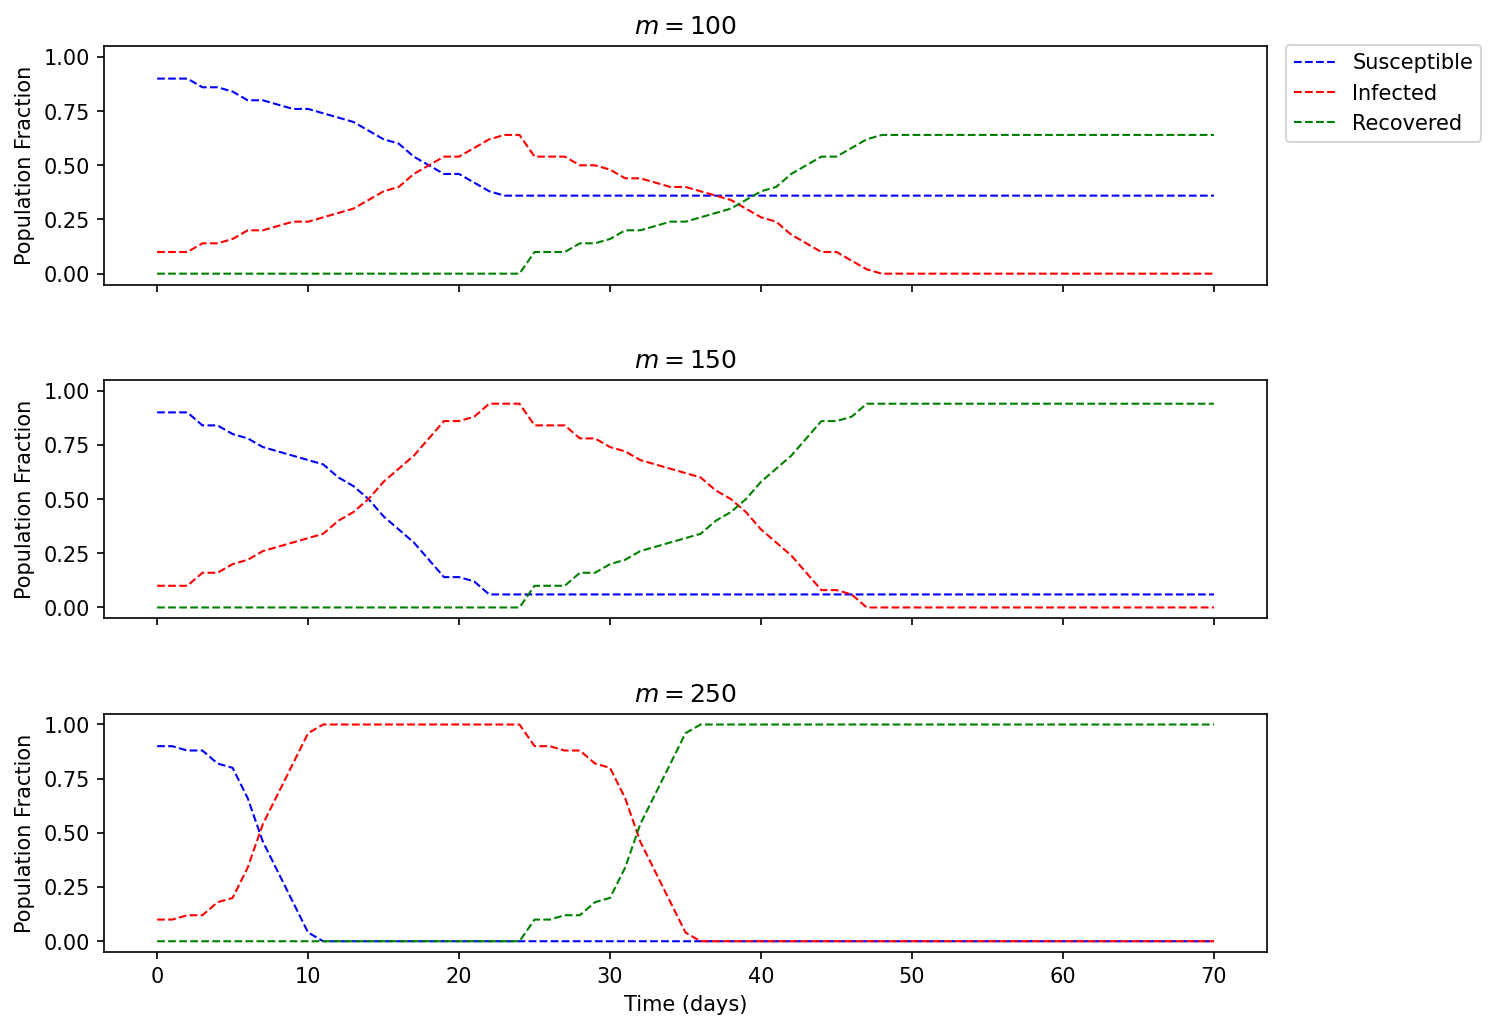

In [8]:
# plot output

SIR_new1 = np.array(SIR_infected)
SIR_new2 = np.array(SIR_recovered)
print('SIR infected: ', end='')
print(SIR_new1, end='\n')
print('SIR recovered: ', end='')
print(SIR_new2)
time = list(range(T+1))


fig, ax = plt.subplots(3, 1,figsize = (10,8),dpi=150, sharex=True, sharey=True)
# fig.suptitle('Diagram of the SIS model', fontsize = 14, x=0.5, y=0.95)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

m = [100, 150, 250]

for i in range(3):
    ax[i].plot(time,1-SIR_new1[i]/n-SIR_new2[i]/n, 'b--',linewidth=1, label = 'Susceptible')
    ax[i].plot(time,SIR_new1[i]/n, 'r--',linewidth=1, label = 'Infected')
    ax[i].plot(time,SIR_new2[i]/n, 'g--',linewidth=1, label = 'Recovered')
    ax[i].set_title(f'$m = {m[i]}$')
    ax[i].set_ylabel('Population Fraction')


lines,labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels,bbox_to_anchor=(1.05,0.89)) 

plt.xlabel('Time (days)')

# save plot
plt.savefig(path+'Outputs/G'+str(n)+"_SIR_compared_line_v5.png")

plt.show()    